## IMPORTING THE LIBRARIES

In [1]:
import os

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, StackingRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor

from sklearn.metrics import mean_squared_error, r2_score

## DEFINING THE NUMBER OF CPUS TO WORK WITH

In [2]:
cpus = os.cpu_count()

## IMPORTING THE DATA

In [3]:
def import_data(path):

    dataframe = pd.read_csv(path)

    if 'Unnamed: 0' in dataframe.columns.tolist():
        dataframe = dataframe.drop('Unnamed: 0', axis = 1)
        
    return dataframe

sales = import_data('data/sales.csv')

## SPLITTING THE DATA INTO TWO DATAFRAMES: 80% FOR TRAINING AND 20% FOR TESTING

In [4]:
def split_train_test(dataframe, target):

    X = dataframe.drop(target, axis = 1)
    y = dataframe[target]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

    training_dataframe = pd.concat([X_train, y_train], axis = 1)
    testing_dataframe = pd.concat([X_test, y_test], axis = 1)

    return training_dataframe.reset_index(drop = True), testing_dataframe.reset_index(drop = True)

sales_training, sales_testing = split_train_test(sales, 'sales')

## DEFINING THE MEAN SALES COLUMN USING THE STORE ID AS A REFERENCE

In [5]:
sales_training['store_mean_sales'] = sales_training['store_ID'].map(sales_training.groupby('store_ID').mean()['sales'].to_dict())
sales_testing['store_mean_sales'] = sales_testing['store_ID'].map(sales_training.groupby('store_ID').mean()['sales'].to_dict())

## DROPPING THE STORE ID COLUMN BECAUSE IS NOT GIVING ANY USEFUL INFORMATION

In [6]:
def drop_id(dataframe, id_column):
    
    return dataframe.drop(id_column, axis = 1)

sales_training = drop_id(sales_training, 'store_ID')
sales_testing = drop_id(sales_testing, 'store_ID')

## EXTRACTING THE YEAR, THE MONTH AND THE DAY FROM THE DATE COLUMN. REMOVING THE DATE COLUMN

In [7]:
def process_date(dataframe, date_column):

    dataframe[date_column] = pd.to_datetime(dataframe[date_column])

    dataframe['year'] = dataframe[date_column].dt.year
    dataframe['month'] = dataframe[date_column].dt.month
    dataframe['day'] = dataframe[date_column].dt.day

    dataframe = dataframe.drop(date_column, axis = 1)
    
    return dataframe

sales_training = process_date(sales_training, 'date')
sales_testing = process_date(sales_testing, 'date')

## REPLACING THE VALUES FROM THE COLUMNS THAT WE ARE GOING TO ONE HOT ENCODE

In [8]:
day_of_week = {1: 'monday', 2: 'tuesday', 3: 'wednesday',
               4: 'thursday', 5: 'friday', 6: 'saturday', 7: 'sunday'}

state_holiday = {'0': 'state_holiday_0', 'a': 'state_holiday_a', 
                 'b': 'state_holiday_b', 'c': 'state_holiday_c'}

year = {2013: 'year_2013', 2014: 'year_2014', 2015: 'year_2015'}

month = {1: 'january', 2: 'february', 3: 'march',
         4: 'april', 5: 'may', 6: 'june', 7: 'july',
         8: 'august', 9: 'september', 10: 'october',
         11: 'november', 12: 'december'}

def replace_values(dataframe, columns, values):

    for column, replacement in zip(columns, values):
        dataframe[column] = dataframe[column].replace(replacement)

    return dataframe

sales_training = replace_values(sales_training, ['day_of_week', 'state_holiday', 'year', 'month'],
                                [day_of_week, state_holiday, year, month])

sales_testing = replace_values(sales_testing, ['day_of_week', 'state_holiday', 'year', 'month'],
                               [day_of_week, state_holiday, year, month])

## ONE HOT ENCODING THE DAY OF WEEK AND THE STATE HOLIDAY COLUMNS

In [9]:
def one_hot_encode(dataframe_training, dataframe_testing, to_encode_columns):

    encoder = OneHotEncoder().fit(dataframe_training[to_encode_columns])

    encoded_columns_array_tr = encoder.transform(dataframe_training[to_encode_columns]).toarray()
    encoded_columns_array_te = encoder.transform(dataframe_testing[to_encode_columns]).toarray()

    encoder_columns = list()
    columns_to_drop = list()

    for columns in encoder.categories_:
        columns_to_drop.append(columns[0])
        for column in columns:
            encoder_columns.append(column)

    encoded_columns_dataframe_tr = pd.DataFrame(data = encoded_columns_array_tr, columns = encoder_columns)
    encoded_columns_dataframe_te = pd.DataFrame(data = encoded_columns_array_te, columns = encoder_columns)

    dataframe_training = pd.concat([dataframe_training, encoded_columns_dataframe_tr], axis = 1).drop(to_encode_columns, axis = 1)
    dataframe_testing = pd.concat([dataframe_testing, encoded_columns_dataframe_te], axis = 1).drop(to_encode_columns, axis = 1)

    return dataframe_training, dataframe_testing, encoder

sales_training, sales_testing, encoder = one_hot_encode(sales_training, sales_testing, 
                                                        ['day_of_week', 'state_holiday', 'year', 'month'])

## SCALING THE NUMERICAL COLUMNS USING THE STANDARD SCALER

In [10]:
def scale_data(dataframe_training, dataframe_testing, to_scale_columns):

    scaler = StandardScaler().fit(dataframe_training[to_scale_columns])

    dataframe_training[to_scale_columns] = scaler.transform(dataframe_training[to_scale_columns])
    dataframe_testing[to_scale_columns] = scaler.transform(dataframe_testing[to_scale_columns])

    return dataframe_training, dataframe_testing, scaler

sales_training, sales_testing, scaler = scale_data(sales_training, sales_testing, 
                                                   ['nb_customers_on_day', 'day', 'store_mean_sales'])

## SORTING THE COLUMNS FROM INPUT VARIABLES TO TARGET VARIABLE

In [11]:
def sort_columns(dataframe, target):

    columns_order = [column for column in dataframe.columns if column != 'sales'] + ['sales']
    
    return dataframe[columns_order]

sales_training = sort_columns(sales_training, 'sales')
sales_testing = sort_columns(sales_testing, 'sales')

## SPLITTING THE TRAINING DATA USING ONE CONDITION: IF THE SHOP IS OPEN OR NOT

In [12]:
sales_training_open = sales_training[sales_training['open'] == 1].drop('open', axis = 1)
sales_testing_open = sales_testing[sales_testing['open'] == 1].drop('open', axis = 1)
open_column_testing = sales_testing['open']

## FILTERING THE COLUMNS THAT HAS A CORRELATION LOWER THAN 0.1 WITH THE TARGET

In [13]:
def filter_columns(dataframe, correlation, target):

    important_columns = list()

    for column in dataframe.columns:
        if abs(dataframe[column].corr(dataframe[target])) > correlation:
            important_columns.append(column)

    return dataframe[important_columns], important_columns

sales_training_open, selected_columns = filter_columns(sales_training_open, 0.1, 'sales')
sales_testing_open = sales_testing_open[selected_columns]

## VISUALIZING THE CORRELATION BETWEEN THE SELECTED VARIABLES

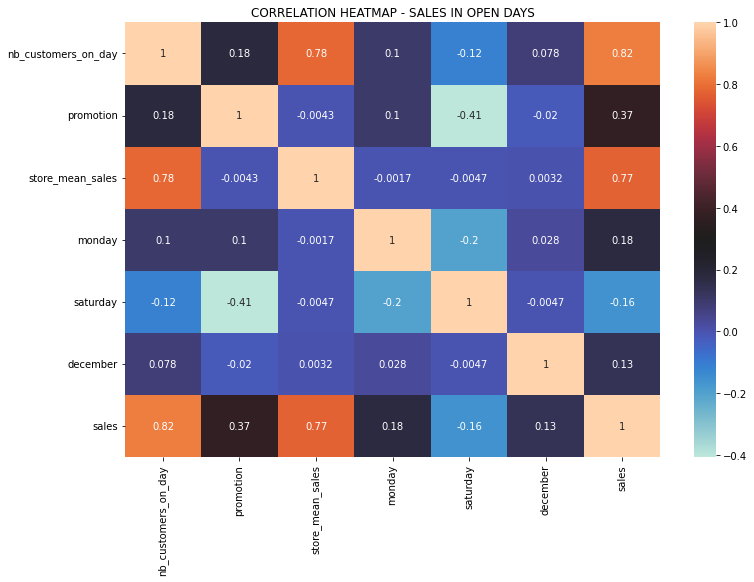

In [14]:
fig = plt.figure(figsize = (12, 8))
plt.title('CORRELATION HEATMAP - SALES IN OPEN DAYS')
sns.heatmap(sales_training_open.corr(), annot = True, cmap = 'icefire')
plt.show()

## SPLITTING THE TARGET VARIABLE FROM THE INPUT VARIABLES IN THE TRAINING AND THE TESTING DATAFRAMES

In [15]:
def split_columns(dataframe, target):

    X = dataframe.drop(target, axis = 1)
    y = dataframe[target]

    return X, y

X_train_open, y_train_open = split_columns(sales_training_open, 'sales')
X_test_open, y_test_open = split_columns(sales_testing_open, 'sales')

## CREATING MULTIPLE MODELS TO PREDICT THE SALES PER DAY ONLY IN THE DAYS THAT THE SHOPS ARE OPEN

In [16]:
def train_models(training_x, training_y, testing_x, testing_y, models):

    models_names = list()
    training_scores = list()
    testing_scores = list()
    rmse_scores_training = list()
    rmse_scores_test = list()

    for model in models:

        model.fit(training_x, training_y)
        predicitons_training = model.predict(training_x)
        predictions_test = model.predict(testing_x)
        models_names.append(type(model).__name__)
        training_scores.append(round(model.score(training_x, training_y), 2))
        testing_scores.append(round(model.score(testing_x, testing_y), 2))
        rmse_scores_training.append(mean_squared_error(training_y, predicitons_training, squared = False))
        rmse_scores_test.append(mean_squared_error(testing_y, predictions_test, squared = False))

    results = pd.DataFrame()

    results['model_name'] = models_names
    results['training_score'] = training_scores
    results['testing_score'] = testing_scores
    results['rmse_training'] = rmse_scores_training
    results['rmse_test'] = rmse_scores_test

    return results

models_to_test = [LinearRegression(n_jobs = cpus - 1), XGBRegressor(n_jobs = cpus - 1), 
                  GradientBoostingRegressor(), CatBoostRegressor(verbose = 0)]

models_results = train_models(X_train_open, y_train_open, X_test_open, y_test_open, models_to_test)

## SHOWING THE PERFORMANCE OF THE MODELS

In [17]:
models_results

,model_name,training_score,testing_score,rmse_training,rmse_test
0,LinearRegression,0.82,0.82,1319.840117,1325.599181
1,XGBRegressor,0.93,0.93,815.374464,837.952830
2,GradientBoostingRegressor,0.87,0.87,1118.630719,1128.499421
3,CatBoostRegressor,0.90,0.89,991.722960,1005.614525


## CREATING A STACKING MODEL WITH THE FOUR TESTED MODELS

In [18]:
regressors = [('lr', LinearRegression()), ('xgb', XGBRegressor()), ('cat', CatBoostRegressor(verbose = False))]

final_regressor = StackingRegressor(estimators = regressors, final_estimator = GradientBoostingRegressor())

final_regressor.fit(X_train_open, y_train_open)

KeyboardInterrupt: 

## SELECTING THE FINAL MODEL AND CREATING THE PIPELINE FOR THE PREDICTIONS IN THE VALIDATION DATA

In [ ]:
def predict_pipeline(testing, columns, target, open, model):

    columns.remove(target)
    X_test = testing.drop(target, axis = 1)
    X_test = X_test[columns]
    predictions = list()
    position = 0

    for row in X_test.values:
        if open[position] != 0:
            row = pd.DataFrame(data = [row], columns = list(X_test.columns))
            prediction = model.predict(row)[0]
            predictions.append(prediction)
            position += 1
        else:
            predictions.append(0.0)
            position += 1

    return predictions

predictions_test = predict_pipeline(sales_testing, selected_columns, 'sales', 
                                    open_column_testing, final_regressor)

## EVALUATING THE PREDICTIONS FROM THE DEFINED PIPELINE

In [ ]:
def evaluate_pipeline(testing, target, predictions_test):

    y_test = testing[target]
    
    model_r2 = r2_score(y_test, predictions_test)
    rmse = mean_squared_error(y_test, predictions_test, squared = False)

    return model_r2, rmse

GB_r2_score, GB_rmse = evaluate_pipeline(sales_testing, 'sales', predictions_test)

print(f'\nSTACKED REGRESSOR - PIPELINE METRICS')
print(f'------------------------------------\n')

print(f'- R2 SCORE: {round(GB_r2_score, 2)}')
print(f'- RMSE: {round(GB_rmse, 2)}')


XGBOOST REGRESSOR - PIPELINE METRICS
------------------------------------

- R2 SCORE: 0.96
- RMSE: 747.52
